In [2]:
import numpy as np
import scipy
import scipy.stats
import torch as t

import matplotlib.pyplot as plt
from IPython.display import clear_output, display

from torch.nn import Sequential, Linear, ReLU, LeakyReLU, Dropout, Sigmoid

In [3]:
%matplotlib inline

In [4]:
if t.cuda.is_available():
    if t.cuda.device_count()>1:
        device = t.device('cuda:1')
    else:
        device = t.device('cuda')   
else:
    device = t.device('cpu')

/home/vlad_f/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
device
# device=t.device('cpu') #Overrride the above device choice

device(type='cpu')

Generate the sample 2D distribution: uniform from unit circle.  

In [6]:
angle = np.random.uniform(-np.pi,np.pi,(1000,1)).astype('float32')
data = np.concatenate((np.cos(angle), np.sin(angle)),axis=1)

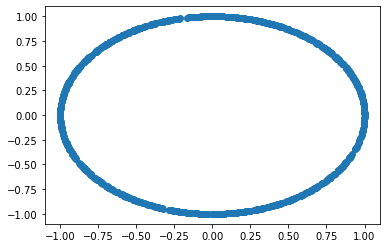

In [7]:
plt.scatter(data[:,0], data[:,1])

In [8]:
data_t = t.from_numpy(data)

In [9]:
data_t

tensor([[ 0.7861,  0.6181],
        [-0.4799,  0.8773],
        [ 0.4355, -0.9002],
        ...,
        [-0.9870,  0.1609],
        [ 0.9912,  0.1321],
        [ 0.7774,  0.6290]])

In [10]:
class Discriminator(t.nn.Module):
    def __init__(self, hidden_dim):
        super(Discriminator, self).__init__()
        self.model = t.nn.Sequential(
            t.nn.Linear(2, hidden_dim),
            t.nn.ReLU(),
            t.nn.Dropout(0.3),
            t.nn.Linear(hidden_dim, hidden_dim//2),
            t.nn.ReLU(),
            t.nn.Dropout(0.3),
            t.nn.Linear(hidden_dim//2, hidden_dim//4),
            t.nn.ReLU(),
            t.nn.Dropout(0.3),
            t.nn.Linear(hidden_dim//4, 1),
            t.nn.Sigmoid()
         )
    
    def forward(self, x):
        return self.model(x)
        
            

discriminator = Discriminator(256)

In [11]:
discriminator = discriminator.to(device) 

In [12]:
class Generator(t.nn.Module):
    def __init__(self, hidden_dim):
        super(Generator, self).__init__()
        self.model = t.nn.Sequential(
            t.nn.Linear(2, hidden_dim),
            t.nn.ReLU(),
            t.nn.Linear(hidden_dim, hidden_dim*2),
            t.nn.ReLU(),
            t.nn.Linear(hidden_dim*2, 2)
        )

    def forward(self, x):
        return self.model(x)

generator = Generator(16)

In [13]:
generator= generator.to(device)

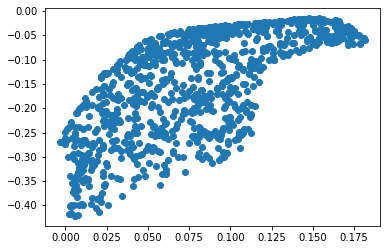

In [14]:
out_t = generator(t.empty(1000,2, device=device).uniform_(-1,1));
plt.scatter(out_t.data.cpu().numpy()[:,0],out_t.data.cpu().numpy()[:,1])

In [15]:
d_optimizer = t.optim.Adam(discriminator.parameters(), lr=0.0002)

In [16]:
g_optimizer = t.optim.Adam(generator.parameters(), lr=0.0002)

### Problem 1

Implement the GAN train loop that will train GAN to generate from the sample distribution.  

In [17]:
batch_size = 32
train_loader = t.utils.data.DataLoader(
    dataset=data_t, 
    batch_size=batch_size, 
    drop_last=True,
    shuffle=True
)
next(iter(train_loader))

tensor([[ 0.3935,  0.9193],
        [ 0.0562, -0.9984],
        [-0.7656,  0.6433],
        [ 0.8728, -0.4881],
        [-0.9232,  0.3843],
        [ 0.8595, -0.5111],
        [ 0.0300,  0.9996],
        [ 0.9068,  0.4215],
        [-0.0434,  0.9991],
        [ 0.3106,  0.9505],
        [ 0.9265,  0.3763],
        [-0.6826, -0.7308],
        [-0.4286, -0.9035],
        [-0.9929, -0.1188],
        [-0.0442,  0.9990],
        [ 0.3410, -0.9401],
        [ 0.4502,  0.8929],
        [ 0.2952,  0.9554],
        [ 0.7952, -0.6064],
        [ 0.9659, -0.2590],
        [-0.7247, -0.6890],
        [ 0.9114,  0.4114],
        [-0.0507, -0.9987],
        [ 0.4979,  0.8672],
        [ 0.4091, -0.9125],
        [ 0.0772, -0.9970],
        [ 0.9445,  0.3287],
        [-0.8152,  0.5792],
        [-0.9760, -0.2177],
        [-0.5751, -0.8181],
        [-0.9971,  0.0763],
        [ 0.5793, -0.8151]])

In [18]:
epochs = 300
loss = t.nn.BCELoss()

for epoch in range(epochs):
    for n, true_data in enumerate(train_loader):
        
        true_labels = t.ones((batch_size, 1))
        fake_samples = t.randn((batch_size, 2))
        gen_data = generator(fake_samples)
        gen_labels = t.zeros((batch_size, 1))
        
        train_data = t.cat(
            (
                true_data, 
                gen_data
            )
        )
        train_labels = t.cat(
            (
                true_labels, 
                gen_labels
            )
        )

        # Training discriminator
        discriminator.zero_grad()
        dis_output = discriminator(train_data)
        dis_loss = loss(dis_output, train_labels)
        dis_loss.backward()
        d_optimizer.step()

        # One more time data from fake distriution
        fake_samples = t.randn((batch_size, 2))

        # Training generator
        generator.zero_grad()
        gen_data = generator(fake_samples)
        dis_gen_output= discriminator(gen_data)
        gen_loss = loss(dis_gen_output, true_labels)
        gen_loss.backward()
        g_optimizer.step()

        # Output value of loss function
        if epoch % 10 == 0 and n==batch_size-2:
            print(f"Epoch: {epoch} Loss D.: {dis_loss}")
            print(f"Epoch: {epoch} Loss G.: {gen_loss}")

Epoch: 0 Loss D.: 0.6537545919418335
Epoch: 0 Loss G.: 0.7688683271408081
Epoch: 10 Loss D.: 0.5381139516830444
Epoch: 10 Loss G.: 1.0804656744003296
Epoch: 20 Loss D.: 0.6735671758651733
Epoch: 20 Loss G.: 0.8046658635139465
Epoch: 30 Loss D.: 0.5822659730911255
Epoch: 30 Loss G.: 1.0427179336547852
Epoch: 40 Loss D.: 0.6192072629928589
Epoch: 40 Loss G.: 1.4159266948699951
Epoch: 50 Loss D.: 0.688879668712616
Epoch: 50 Loss G.: 1.104803442955017
Epoch: 60 Loss D.: 0.605127215385437
Epoch: 60 Loss G.: 1.1255548000335693
Epoch: 70 Loss D.: 0.6642903685569763
Epoch: 70 Loss G.: 1.0492172241210938
Epoch: 80 Loss D.: 0.6322795748710632
Epoch: 80 Loss G.: 1.0416184663772583
Epoch: 90 Loss D.: 0.7004666328430176
Epoch: 90 Loss G.: 0.7529876828193665
Epoch: 100 Loss D.: 0.6463143825531006
Epoch: 100 Loss G.: 0.8820797204971313
Epoch: 110 Loss D.: 0.6230667233467102
Epoch: 110 Loss G.: 0.8522183895111084
Epoch: 120 Loss D.: 0.6533628702163696
Epoch: 120 Loss G.: 0.8412818908691406
Epoch: 130 

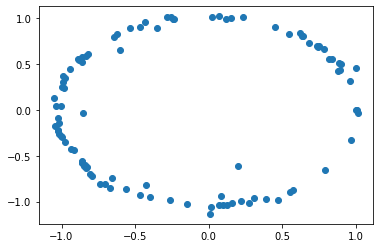

In [19]:
fake_samples = t.randn(100, 2)
generated_samples = generator(fake_samples)
generated_samples = generated_samples.detach()
plt.scatter(generated_samples[:, 0], generated_samples[:, 1])

### Problem 2

Use another sampling distribution. One that is not concentrated on a line e.g. an ellipse. 

In [20]:
class Discriminator(t.nn.Module):
    def __init__(self, hidden_dim):
        super(Discriminator, self).__init__()
        self.model = t.nn.Sequential(
            t.nn.Linear(2, hidden_dim),
            t.nn.ReLU(),
            t.nn.Dropout(0.3),
            t.nn.Linear(hidden_dim, hidden_dim//2),
            t.nn.ReLU(),
            t.nn.Dropout(0.3),
            t.nn.Linear(hidden_dim//2, hidden_dim//4),
            t.nn.ReLU(),
            t.nn.Dropout(0.3),
            t.nn.Linear(hidden_dim//4, 1),
            t.nn.Sigmoid()
         )
    
    def forward(self, x):
        return self.model(x)
        
            

discriminator = Discriminator(512)

In [21]:
class Generator(t.nn.Module):
    def __init__(self, hidden_dim):
        super(Generator, self).__init__()
        self.model = t.nn.Sequential(
            t.nn.Linear(2, hidden_dim),
            t.nn.ReLU(),
            t.nn.Linear(hidden_dim, hidden_dim*2),
            t.nn.ReLU(),
            t.nn.Linear(hidden_dim*2, 2)
        )

    def forward(self, x):
        return self.model(x)

generator = Generator(128)

In [22]:
d_optimizer = t.optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = t.optim.Adam(generator.parameters(), lr=0.0002)

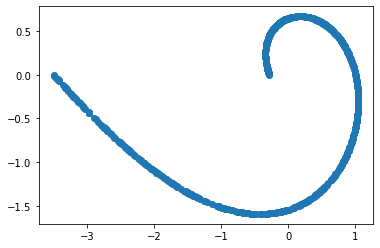

In [25]:
angle = np.random.uniform(-np.pi,np.pi,(1000,1)).astype('float32')
data = np.concatenate(
    (
        np.cos(angle)*np.exp(-np.tan(angle/3.5)), 
        np.sin(angle)*np.exp(-np.sin(angle/3.5))
    ),
    axis=1
)
plt.scatter(data[:,0], data[:,1])
plt.show()

In [26]:
batch_size = 32
train_loader = t.utils.data.DataLoader(
    dataset=data, 
    batch_size=batch_size, 
    drop_last=True,
    shuffle=True
)

In [27]:
epochs = 300
loss = t.nn.BCELoss()

for epoch in range(epochs):
    for n, true_data in enumerate(train_loader):
        
        true_labels = t.ones((batch_size, 1))
        fake_samples = t.randn((batch_size, 2))
        gen_data = generator(fake_samples)
        gen_labels = t.zeros((batch_size, 1))
        
        train_data = t.cat(
            (
                true_data, 
                gen_data
            )
        )
        train_labels = t.cat(
            (
                true_labels, 
                gen_labels
            )
        )

        # Training discriminator
        discriminator.zero_grad()
        dis_output = discriminator(train_data)
        dis_loss = loss(dis_output, train_labels)
        dis_loss.backward()
        d_optimizer.step()

        # One more time data from fake distriution
        fake_samples = t.randn((batch_size, 2))

        # Training generator
        generator.zero_grad()
        gen_data = generator(fake_samples)
        dis_gen_output= discriminator(gen_data)
        gen_loss = loss(dis_gen_output, true_labels)
        gen_loss.backward()
        g_optimizer.step()

        # Output value of loss function
        if epoch % 10 == 0 and n==batch_size-2:
            print(f"Epoch: {epoch} Loss D.: {dis_loss}")
            print(f"Epoch: {epoch} Loss G.: {gen_loss}")

Epoch: 0 Loss D.: 0.5846243500709534
Epoch: 0 Loss G.: 0.7940182089805603
Epoch: 10 Loss D.: 0.7843826413154602
Epoch: 10 Loss G.: 0.9435797333717346
Epoch: 20 Loss D.: 0.6644806861877441
Epoch: 20 Loss G.: 0.7508202195167542
Epoch: 30 Loss D.: 0.6022336483001709
Epoch: 30 Loss G.: 0.8567458987236023
Epoch: 40 Loss D.: 0.6595537662506104
Epoch: 40 Loss G.: 0.9265908002853394
Epoch: 50 Loss D.: 0.6805157661437988
Epoch: 50 Loss G.: 0.7731356620788574
Epoch: 60 Loss D.: 0.6555159091949463
Epoch: 60 Loss G.: 0.6887636780738831
Epoch: 70 Loss D.: 0.6587364077568054
Epoch: 70 Loss G.: 0.7007387280464172
Epoch: 80 Loss D.: 0.6789387464523315
Epoch: 80 Loss G.: 0.7431467771530151
Epoch: 90 Loss D.: 0.7233270406723022
Epoch: 90 Loss G.: 0.6632585525512695
Epoch: 100 Loss D.: 0.6954920887947083
Epoch: 100 Loss G.: 0.7162776589393616
Epoch: 110 Loss D.: 0.6787104606628418
Epoch: 110 Loss G.: 0.6853727698326111
Epoch: 120 Loss D.: 0.6940711140632629
Epoch: 120 Loss G.: 0.709754467010498
Epoch: 13

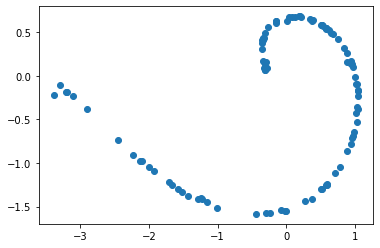

In [28]:
fake_samples = t.randn(100, 2)
generated_samples = generator(fake_samples)
generated_samples = generated_samples.detach()
plt.scatter(generated_samples[:, 0], generated_samples[:, 1])

In [29]:
t.save(generator, './generator_Fedoriuk_Vladyslav.pt')